In [49]:
import nmresearch as nmr
import scipy as sp
import numpy as np
import matplotlib.pyplot as plt

In [50]:
import qutip as qt
from qutip import hinton, identity, to_super, sigmaz, tensor, tensor_contract, sigmax, projection, jmat, basis, propagator

In [51]:
sqrt2 = np.sqrt(2)
isqrt2 = 1/np.sqrt(2)

In [52]:
SzNV = tensor(jmat(1/2,'z'), identity([2]))
SxNV = tensor(jmat(1/2,'x'),identity([2]))
SyNV = tensor(jmat(1/2,'y'),identity([2]))
SzX = tensor(identity(2), jmat(1/2,'z'))
SxX = tensor(identity(2), jmat(1/2,'x'))
SyX = tensor(identity(2), jmat(1/2,'y'))

In [53]:
GHz=1e3
MHz=1
kHz=1e-3

ms=1e3
us=1
ns=1e-3

B = 360
omegaNV =  2.87 * GHz - (2.8 * B)
omegaX = 2.8 * B
D = 60 * kHz
Omega = 1 * MHz

T1e = 1*ms
T2e = 4*us
T1n = 10*ms
T2n = 500*us

T1e_rho = 100*us

In [54]:
H0 =  2*np.pi*(Omega * (SxNV + SxX)  + 2 * D * SzNV * SzX)

In [55]:
NvPi2 = (-1j*(np.pi/2)*SyNV).expm()
XPi2 = (-1j*(np.pi/2)*SyX).expm()

In [56]:
nv0 = basis(2,0)
nv1 = basis(2,1)
x0 = basis(2,0)
x1 = basis(2,1)

In [57]:
rho0 = 0.5*tensor(projection(2,0,0), identity([2]))
rho1 = NvPi2*rho0*NvPi2.conj().trans()
rho1

Quantum object: dims=[[2, 2], [2, 2]], shape=(4, 4), type='oper', dtype=Dense, isherm=True
Qobj data =
[[0.25 0.   0.25 0.  ]
 [0.   0.25 0.   0.25]
 [0.25 0.   0.25 0.  ]
 [0.   0.25 0.   0.25]]

In [58]:
NV_c_ops = [1/(2*T1e) * SxNV, 1/(2*T1e) * SyNV, 1/(2*T2e) * SzNV]
X_c_ops = [1/(2*T1e) * SxX, 1/(2*T1e) * SyX, 1/(2*T2e) * SzX]
lindblad_ops = NV_c_ops + X_c_ops

In [59]:
t_list = np.arange(0,15,.05)*us

In [60]:
res = qt.mesolve(H0, rho1, t_list, c_ops=lindblad_ops)

In [61]:
HH_nv = np.zeros(len(t_list),dtype=np.complex128)
HH_x = np.zeros(len(t_list),dtype=np.complex128)

for idx, state in enumerate(res.states):
    rhof = XPi2.conj().trans()*NvPi2.conj().trans() * state * NvPi2 * XPi2
    HH_nv[idx] = 2*qt.expect(rhof, SzNV)
    HH_x[idx] = 2*qt.expect(rhof, SzX)

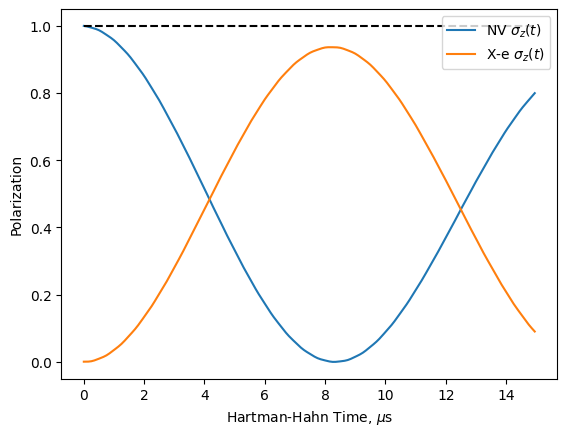

In [62]:
plt.plot(t_list, np.real(HH_nv),label=r"NV $\sigma_z(t)$")
plt.plot(t_list, np.real(HH_x),label=r"X-e $\sigma_z(t)$")
plt.hlines(1,0,t_list[-1],color="k",linestyle="--")
plt.xlabel(r"Hartman-Hahn Time, $\mu$s")
plt.ylabel("Polarization")
plt.legend()
plt.show()

In [63]:
t_swap = t_list[np.argmin(HH_nv)]

In [64]:
t_swap

8.3

In [65]:
np.max(HH_x)

(0.9366213476947174+0j)

In [66]:
def hartman_hahn(t):
    spin_lock = propagator(H0, t,c_ops=lindblad_ops)
    simul_pulse = X_Pi_2_super * NV_Pi_2_super
    return simul_pulse.conj().trans() * spin_lock * simul_pulse
    
def noise(t):
    return propagator(identity([2,2]), t, c_ops=lindblad_ops)

NV_Pi_2_super = qt.to_super(NvPi2)
X_Pi_2_super = qt.to_super(XPi2)

In [67]:
rho1 = qt.operator_to_vector(0.25*identity([2,2]) + 0.5*SzNV)

In [68]:
rho2 = hartman_hahn(t_swap) * rho1
qt.vector_to_operator(rho2).ptrace(1)

Quantum object: dims=[[2], [2]], shape=(2, 2), type='oper', dtype=Dense, isherm=True
Qobj data =
[[9.68213021e-01 1.95627191e-17]
 [1.47932256e-16 3.17869792e-02]]

In [69]:
rho3 = tensor(projection(2,0,0), qt.vector_to_operator(noise(3*us) * rho2).ptrace(1))
rho3

Quantum object: dims=[[2, 2], [2, 2]], shape=(4, 4), type='oper', dtype=Dense, isherm=True
Qobj data =
[[9.68212670e-01 1.91095448e-17 0.00000000e+00 0.00000000e+00]
 [1.44505376e-16 3.17873304e-02 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00]]

In [70]:
NV_Pi_super = NV_Pi_2_super**2

In [71]:
rho4 = qt.vector_to_operator(hartman_hahn(t_swap/2) * NV_Pi_super * qt.operator_to_vector(rho3))

In [72]:
rho4

Quantum object: dims=[[2, 2], [2, 2]], shape=(4, 4), type='oper', dtype=Dense, isherm=True
Qobj data =
[[ 1.52243105e-02+3.63036280e-16j  3.22994577e-16+1.50232396e-16j
   1.51731691e-16-7.12113185e-17j -6.13933691e-04-4.35330875e-04j]
 [-1.63794501e-16-2.05357039e-16j  4.66462656e-01-2.58000049e-16j
  -1.46817920e-05-4.68652676e-01j  1.21594431e-16-2.46724827e-16j]
 [ 5.18768209e-17+2.01795748e-16j -1.46817920e-05+4.68652676e-01j
   4.72352307e-01-2.13038748e-16j  7.57486115e-17+1.80702427e-16j]
 [-6.13933691e-04+4.35330875e-04j -1.99932797e-16+3.55043288e-16j
  -9.73412340e-17-3.91268655e-16j  4.59607265e-02-1.10796381e-16j]]

In [73]:
bell = isqrt2*(tensor(basis(2,1), basis(2,0)) - 1j*tensor(basis(2,0), basis(2,1)))

In [78]:
rho_bell = bell * bell.trans().conj()
rho_bell

Quantum object: dims=[[2, 2], [2, 2]], shape=(4, 4), type='oper', dtype=Dense, isherm=True
Qobj data =
[[0. +0.j  0. +0.j  0. +0.j  0. +0.j ]
 [0. +0.j  0.5+0.j  0. -0.5j 0. +0.j ]
 [0. +0.j  0. +0.5j 0.5+0.j  0. +0.j ]
 [0. +0.j  0. +0.j  0. +0.j  0. +0.j ]]

In [79]:
qt.concurrence(rho_bell)

0.9999999999999998

In [80]:
qt.fidelity(rho4, rho_bell)

0.9685350573232432

In [81]:
qt.concurrence(rho4)

0.8844008957969894